In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
DATA_PROCESSED = Path("../data/processed")

for p in [DATA_RAW, DATA_INTERIM, DATA_PROCESSED]:
    p.mkdir(parents=True, exist_ok=True)

In [3]:
sirh = pd.read_csv(DATA_RAW / "extrait_sirh.csv")
evals = pd.read_csv(DATA_RAW / "extrait_eval.csv")
survey = pd.read_csv(DATA_RAW / "extrait_sondage.csv")

for name, df in [("SIRH", sirh), ("EVALS", evals), ("SURVEY", survey)]:
    print(f"\n{name}: {df.shape} lignes, {df.columns.size} colonnes")
    display(df.head(3))



SIRH: (1470, 12) lignes, 12 colonnes


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0



EVALS: (1470, 10) lignes, 10 colonnes


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %



SURVEY: (1470, 12) lignes, 12 colonnes


,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


In [4]:
def quick_info(df, name):
    print(f"==== {name} ====")
    display(df.dtypes.to_frame("dtype"))
    print("NA par colonne:")
    display(df.isna().sum().sort_values(ascending=False).to_frame("na"))
    print("Dupliqués (lignes):", df.duplicated().sum())

quick_info(sirh, "SIRH")
quick_info(evals, "EVALS")
quick_info(survey, "SURVEY")


==== SIRH ====


,dtype
id_employee,int64
age,int64
genre,object
revenu_mensuel,int64
statut_marital,object
departement,object
poste,object
nombre_experiences_precedentes,int64
nombre_heures_travailless,int64
annee_experience_totale,int64


NA par colonne:


,na
id_employee,0
age,0
genre,0
revenu_mensuel,0
statut_marital,0
departement,0
poste,0
nombre_experiences_precedentes,0
nombre_heures_travailless,0
annee_experience_totale,0


Dupliqués (lignes): 0
==== EVALS ====


,dtype
satisfaction_employee_environnement,int64
note_evaluation_precedente,int64
niveau_hierarchique_poste,int64
satisfaction_employee_nature_travail,int64
satisfaction_employee_equipe,int64
satisfaction_employee_equilibre_pro_perso,int64
eval_number,object
note_evaluation_actuelle,int64
heure_supplementaires,object
augementation_salaire_precedente,object


NA par colonne:


,na
satisfaction_employee_environnement,0
note_evaluation_precedente,0
niveau_hierarchique_poste,0
satisfaction_employee_nature_travail,0
satisfaction_employee_equipe,0
satisfaction_employee_equilibre_pro_perso,0
eval_number,0
note_evaluation_actuelle,0
heure_supplementaires,0
augementation_salaire_precedente,0


Dupliqués (lignes): 0
==== SURVEY ====


,dtype
a_quitte_l_entreprise,object
nombre_participation_pee,int64
nb_formations_suivies,int64
nombre_employee_sous_responsabilite,int64
code_sondage,int64
distance_domicile_travail,int64
niveau_education,int64
domaine_etude,object
ayant_enfants,object
frequence_deplacement,object


NA par colonne:


,na
a_quitte_l_entreprise,0
nombre_participation_pee,0
nb_formations_suivies,0
nombre_employee_sous_responsabilite,0
code_sondage,0
distance_domicile_travail,0
niveau_education,0
domaine_etude,0
ayant_enfants,0
frequence_deplacement,0


Dupliqués (lignes): 0


In [5]:
# Création d'une clé d'identifiant uniforme
evals["id_employee"] = evals["eval_number"].str.replace("E_", "").astype(int)
survey["id_employee"] = survey["code_sondage"].astype(str).str.lstrip("0").astype(int)

# Fusion des 3 jeux
df = (
    sirh
    .merge(evals, on="id_employee", how="left")
    .merge(survey, on="id_employee", how="left")
)

print("✅ DataFrame central :", df.shape)
df.head()


✅ DataFrame central : (1470, 34)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [6]:
df["a_quitte_l_entreprise"] = df["a_quitte_l_entreprise"].str.strip().str.lower().map({"oui": 1, "non": 0})

df["augementation_salaire_precedente"] = (
    df["augementation_salaire_precedente"]
    .astype(str)
    .str.replace("%", "")
    .str.strip()
    .replace("nan", np.nan)
    .astype(float)
)


In [7]:
print("Taux d'attrition global :", df["a_quitte_l_entreprise"].mean().round(3))
print(df["a_quitte_l_entreprise"].value_counts())

cols_quanti = [
    "age",
    "revenu_mensuel",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "nombre_experiences_precedentes",
    "annee_experience_totale",
    "satisfaction_employee_environnement",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_actuelle",
    "augementation_salaire_precedente",
]

display(df.groupby("a_quitte_l_entreprise")[cols_quanti].mean().T.round(2))


Taux d'attrition global : 0.161
a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64


a_quitte_l_entreprise,0,1
age,37.56,33.61
revenu_mensuel,6832.74,4787.09
annees_dans_l_entreprise,7.37,5.13
annees_dans_le_poste_actuel,4.48,2.90
nombre_experiences_precedentes,2.65,2.94
annee_experience_totale,11.86,8.24
satisfaction_employee_environnement,2.77,2.46
satisfaction_employee_equipe,2.73,2.60
satisfaction_employee_equilibre_pro_perso,2.78,2.66
note_evaluation_actuelle,3.15,3.16


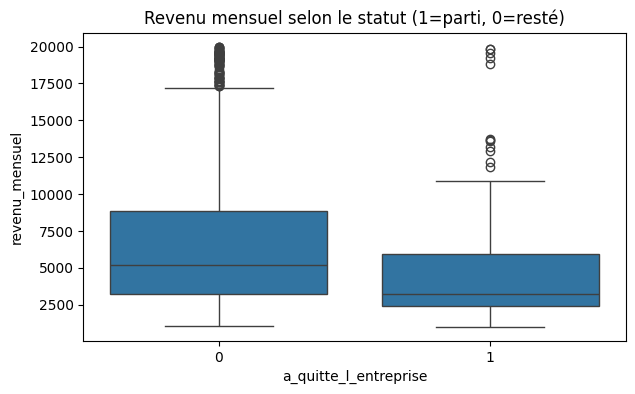

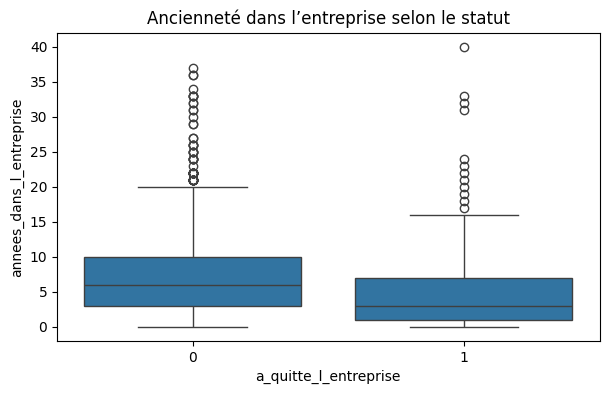

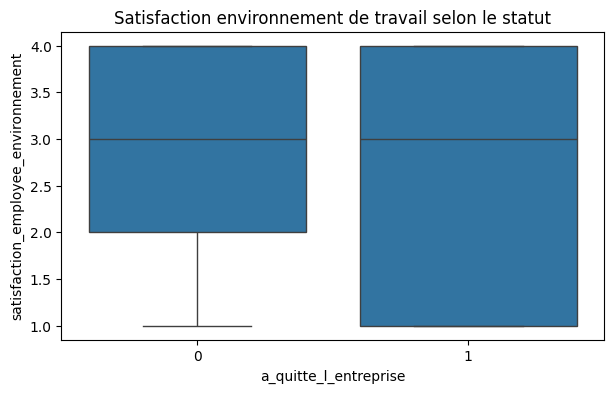

In [8]:
plt.figure(figsize=(7,4))
sns.boxplot(x="a_quitte_l_entreprise", y="revenu_mensuel", data=df)
plt.title("Revenu mensuel selon le statut (1=parti, 0=resté)")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="a_quitte_l_entreprise", y="annees_dans_l_entreprise", data=df)
plt.title("Ancienneté dans l’entreprise selon le statut")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="a_quitte_l_entreprise", y="satisfaction_employee_environnement", data=df)
plt.title("Satisfaction environnement de travail selon le statut")
plt.show()


In [9]:
df.to_parquet("../data/processed/technova_central_clean.parquet", index=False)